# word2vec

word2vec是由谷歌公司Tomas Mikolov领导的研究小组于2013年创建的模型组。这些模型是无监督的，它以大型文本语料作为输入，并生成词汇的向量空间。word2vec向量空间维度通常低于one-hot编码的字典大小的向量空间维度，和one-hot向量空间的稀疏性相比，word2vec向量空间更稠密

word2vec由两种结构：
- (1)连续词袋模型(Continuous Bag Of Words, CBOW)
- (2)skip-gram模型

## CBOW模型

CBOW模型包含三层:输入层、映射层、输出层，其架构如下图:
<img src='./datasets/cbow.png'>

w(t)为输入词，在已知词w(t)的前提下预测w(t)的上下文w(t-2)、w(t-1)、w(t+1)、w(t+2),条件概率为:$p(w|context(w))$。目标函数为:

$$\sum logp(w|context(w))$$

CBOW模型训练其实就是根据某个词前后若干个词来预测该词，这其实可以看出是多分类，最朴素的想法就是直接使用softmax来分别计算每个词对应的归一化的概率，但对于动辄十几万词汇量的场景中使用softmax计算量太大，于是需要用一种二分类组合形式的hierarchical softmax,即输出一颗二叉树

## Skip-Gram模型

Skip-Gram模型包含三层:输入层、映射层、输出层，其架构如下图:
<img src='./datasets/skim-gram.png'>
w(t)为输入词，在已知词w(t)的前提下预测w(t)的上下文w(t-2)、w(t-1)、w(t+1)、w(t+2),条件概率为:$p(context(w)|w)$。目标函数为:

$$\sum logp(context(w)|w)$$

Skip-Gram的基本思想是通过已知词的前提下预测其上下文的词，通过一个例子来说明，假设有个句子：

i love green eggs and ham

接下来，根据Skip-Gram算法基本思想，把这个语句生成由系列(输入，输出)构成的数据集，当上下文窗口大小为1时，love的上下文为[i，green],green的上下文为[love,eggs],依次类推。上面的数据集可以转换成：

datasets = [[love，i],[love，green],[green，love],[green，egges],...,[and，eggs],[and，ham]]

# 使用tensorflow实现skip-gram模型

- (1) 将数据集中word根据其在数据集出现的频数进行降序排列，生成排序后的word序列
- (2) 创建字典，key为word,value为word在序列中的索引
- (3) 将原数据集根据(2)生成对用的‘索引数字’数据集
- (4) 创建skip-gram数据集[输入，输出]，如[1,0],[1,2],[2,1],[2,3]等
- (5) 定义模型
- (6) 训练模型
- (7) 可视化词向量

In [5]:
import zipfile
import tensorflow as tf
import collections
import random
import numpy as np
import math

In [6]:
# 加载数据集 
def load_datasets(filename):
    with zipfile.ZipFile(filename,mode='r') as f:
        data = f.read(f.namelist()[0]).decode('utf-8').split()
        #data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [7]:
words = load_datasets('./datasets/text8.zip')
print(len(words),type(words))

17005207 <class 'list'>


In [8]:
# 创建数据集取出现频率高的前4999个word
def build_datasets(words):
    
    '''
        变量说明：
        word_by_count:[word，word在数据集中出现的次数]，第一项表示['UNK',不在字典中的word的总次数]
        dictionary:[word:index]
        indexs = words中每个word在dictionary中对应的索引
        reverse_dictionary:[index:word]
    '''
    
    vocabulary_size = 5000

    word_by_count = [['UNK',-1]] #UNK表示word未出现在字典中
    word_by_count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()  #word-index
    for word,_ in word_by_count:
        dictionary[word] = len(dictionary)

    unk_count = 0
    indexs = []
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        indexs.append(index)
    word_by_count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    return indexs,word_by_count,dictionary,reverse_dictionary

In [9]:
data_index = 0
# 生成批量数据
def generate_batch(batch_size,num_skips,skip_window):
    global data_index
    
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(indexs[data_index])
        data_index = (data_index + 1) % len(indexs)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0,span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j,0] = buffer[target]
        buffer.append(indexs[data_index])
        data_index = (data_index + 1) % len(indexs)
    return batch,labels

In [11]:
#定义模型
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window),valid_size))
num_sampled = 64

vocabulary_size = 5000

train_dataset = tf.placeholder(tf.int32,shape=(batch_size),name='features')
train_label = tf.placeholder(tf.int32,shape=(batch_size,1),name='labels')
valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

# 变量
embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros((vocabulary_size)))

#查找输入的嵌入词
embed = tf.nn.embedding_lookup(embeddings,train_dataset)

loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights,biases=softmax_biases,
                                                inputs = embed,labels=train_label,num_sampled=num_sampled,num_classes=vocabulary_size))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

# 计算minibatch样本和嵌入之间的相似度
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keepdims=True))
normalized_embedding = embeddings / norm
valid_embedding = tf.nn.embedding_lookup(normalized_embedding,valid_dataset)
similarity = tf.matmul(valid_embedding,tf.transpose(normalized_embedding))

In [12]:
vocabulary_size = 5000
indexs,word_by_count,dictionary,reverse_dictionary = build_datasets(words)

In [24]:
# 训练模型
epoches = 10000
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for epoch in range(epoches):
        batch_data,batch_label = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_dataset:batch_data,train_label:batch_label}
        _,l = sess.run([optimizer,loss],feed_dict=feed_dict)
            
        average_loss += l
        if epoch > 0 and epoch % 2000 == 0:
            average_loss = average_loss / 2000
            print('epoch:{}, average loss:{}'.format(epoch,average_loss))
            average_loss = 0
    sim = similarity.eval()
    for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8
        nearest = (-sim[i,:]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log = '%s %s,' %(log,close_word)
        print(log)
    final_embedding = normalized_embedding.eval()

epoch:2000, average loss:3.653382494926453
epoch:4000, average loss:3.3926756686549635
epoch:6000, average loss:3.3992736542224886
epoch:8000, average loss:3.3177713703513145
Nearest to nine: eight, six, seven, zero, five, three, four, two,
Nearest to an: actor, located, intelligent, the, doesn, fantasy, southeast, rough,
Nearest to may: can, would, could, report, to, poe, grave, free,
Nearest to by: radiation, be, from, was, on, been, www, at,
Nearest to it: he, this, there, that, we, genesis, which, not,
Nearest to than: slightly, danish, bones, airlines, bce, besides, measurement, j,
Nearest to four: six, eight, three, five, seven, nine, two, zero,
Nearest to first: continued, difficulty, steps, union, same, hills, herbert, stock,
Nearest to b: deaths, instruments, specified, l, tracks, java, faster, est,
Nearest to on: in, at, missile, by, structural, after, united, ross,
Nearest to so: wearing, student, southeast, baptism, left, arose, giving, muslim,
Nearest to been: bach, were, 

In [39]:
# 词向量可视化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
num_points = 100
# TSNE提供了一种有效的降维方式，让我们对高于2维数据的聚类结果以二维的方式展示出来
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)

two_d_embeddings = tsne.fit_transform(final_embedding[1:num_points+1,:])

def plot(embeddings,labels):
    plt.figure(figsize=(15,15))
    for i,label in enumerate(labels):
        x,y = embeddings[i,:]
        plt.scatter(x,y)
        plt.annotate(label,(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

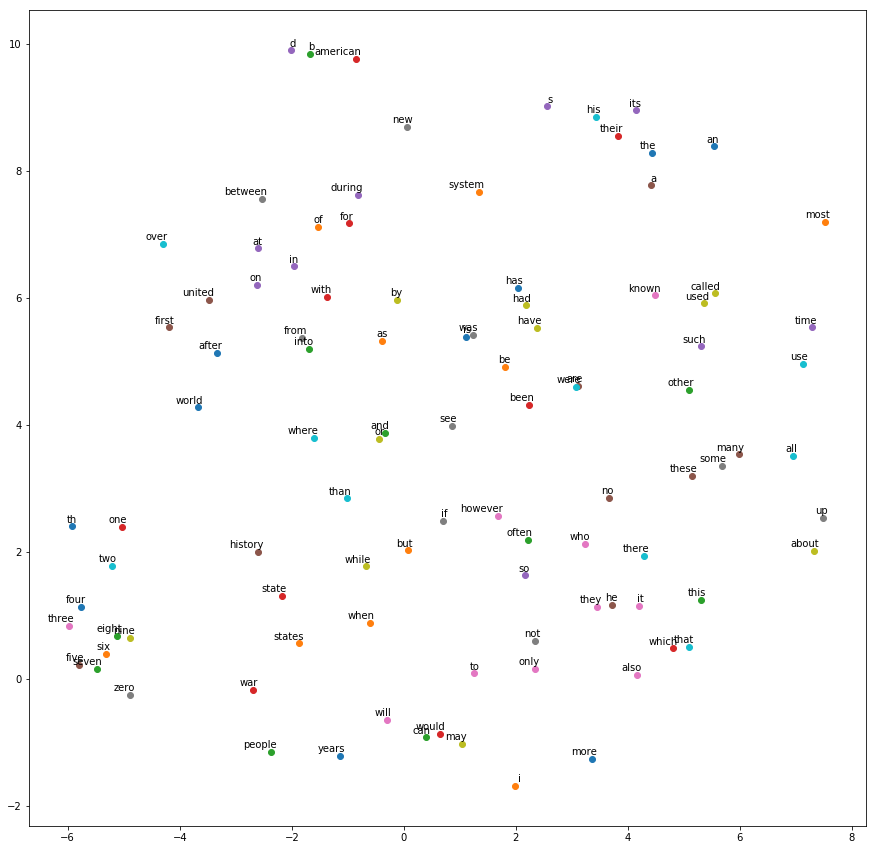

In [40]:
words = [reverse_dictionary[i] for i in range(1,num_points+1)]
plot(two_d_embeddings,words)